# Checking data recovery matrices: modal DOF (`cb.cbtf`)

As with the `cbcheck` demo, we'll use superelement 102. The data recovery matrices were formed in the test directory: "pyyeti/tests/nastran_drm12".

The `cb.cbtf` routine aides in checking the modal DOF. This function performs a base-drive analysis and returns the boundary and modal responses. These are then used by the analyst to plot frequency response curves as a sanity check.

Notes:

* This model uses units of kg, mm, s
* It's a very light-weight truss: mass = 1.755 kg

.. image:: se102.png
<img src="./se102.png" />

---
First, do some imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyyeti import op2, cb, n2p
np.set_printoptions(precision=3, linewidth=130, suppress=True)

Some settings specifically for the jupyter notebook. This and other notebooks are available here:  ``kittyhawk:/home/loads/twidrick/code/pyyeti/docs/tutorials``.

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['savefig.dpi'] = 100.

Need path to data files:

In [3]:
import os
import inspect
pth = os.path.dirname(inspect.getfile(cb))
pth = os.path.join(pth, 'tests')
pth = os.path.join(pth, 'nastran_drm12')

#### Load data recovery matrices

In [4]:
otm = op2.procdrm12(os.path.join(pth, 'drm12'))


Processing "Displacement" requests...
Processing "Acceleration" requests...
Processing "SPC Force" requests...
Processing "Stress" requests...
Processing "Element Force" requests...


In [5]:
sorted(otm.keys())

['ATM',
 'ATM_desc',
 'ATM_id_dof',
 'DTMA',
 'DTMD',
 'DTM_desc',
 'DTM_id_dof',
 'LTMA',
 'LTMD',
 'LTM_desc',
 'LTM_id_dof',
 'SPCFA',
 'SPCFD',
 'SPCF_desc',
 'SPCF_id_dof',
 'STMA',
 'STMD',
 'STM_desc',
 'STM_id_dof']

#### Load the mass and stiffness from the "nas2cam" output

This loads the data into a dict:

In [6]:
nas = op2.rdnas2cam(os.path.join(pth, 'inboard_nas2cam'))
nas.keys()

dict_keys(['maa', 'uset', 'maps', 'selist', 'upids', 'cstm', 'lambda', 'cstm2', 'dnids', 'kaa'])

In [7]:
maa = nas['maa'][102]
kaa = nas['kaa'][102]

#### Get the USET table for the b-set DOF

In [8]:
uset = nas['uset'][102]
b = n2p.mksetpv(uset, 'p', 'b')
usetb = uset[b]
usetb[::6, [0, 3, 4, 5]]

array([[   3.,  600.,    0.,  300.],
       [  11.,  600.,  300.,  300.],
       [  19.,  600.,  300.,    0.],
       [  27.,  600.,    0.,    0.]])

#### Form b-set partition vector into a-set
In this case, we already know the b-set are first but, since we have the nas2cam output, we can use `n2p.mksetpv` to be more general. We'll also get the q-set partition vector for later use.

In [9]:
b = n2p.mksetpv(uset, 'a', 'b')
q = ~b
b = np.nonzero(b)[0]
q = np.nonzero(q)[0]
print('b =', b)
print('q =', q)

b = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
q = [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83]


#### Form the damping matrix
We'll use 2.5% critical damping.

In [10]:
baa = 2*.025*np.sqrt(np.diag(kaa))
baa[b] = 0
baa = np.diag(baa)

---
#### Form rigid-body modes
These are used to define the acceleration(s) of the boundary DOF. Each rigid-body mode defines a consistent acceleration field which is needed for a base-drive (which is really what `cbtf` does).

Note the the second boundary grid is in a different coordinate system.

In [11]:
rbg = n2p.rbgeom_uset(usetb, [600, 150, 150])
rbg

array([[   1.,    0.,    0.,    0.,  150.,  150.],
       [   0.,    1.,    0., -150.,    0.,    0.],
       [   0.,    0.,    1., -150.,    0.,    0.],
       [   0.,    0.,    0.,    1.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    1.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    1.],
       [   0.,    1.,    0., -150.,    0.,    0.],
       [   0.,    0.,    1.,  150.,    0.,    0.],
       [   1.,    0.,    0.,    0.,  150., -150.],
       [   0.,    0.,    0.,    0.,    1.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    1.],
       [   0.,    0.,    0.,    1.,    0.,    0.],
       [   1.,    0.,    0.,    0., -150., -150.],
       [   0.,    1.,    0.,  150.,    0.,    0.],
       [   0.,    0.,    1.,  150.,    0.,    0.],
       [   0.,    0.,    0.,    1.,    0.,    0.],
       [   0.,    0.,    0.,    0.,    1.,    0.],
       [   0.,    0.,    0.,    0.,    0.,    1.],
       [   1.,    0.,    0.,    0., -150.,  150.],
       [   0.,    1.,    0.,  1

Do a check of the mass:

In [12]:
bb = np.ix_(b, b)
rbg.T @ maa[bb] @ rbg

array([[      1.755,       0.   ,      -0.   ,       0.   ,       0.   ,       0.   ],
       [      0.   ,       1.755,      -0.   ,      -0.   ,       0.   ,     772.22 ],
       [     -0.   ,      -0.   ,       1.755,       0.   ,    -772.22 ,      -0.   ],
       [      0.   ,      -0.   ,       0.   ,   35905.202,      -0.   ,      -0.   ],
       [      0.   ,       0.   ,    -772.22 ,      -0.   ,  707976.725,     109.558],
       [      0.   ,     772.22 ,      -0.   ,      -0.   ,     109.558,  707976.725]])

#### Define analysis frequency vector and run `cbtf`
The ``save`` option is useful for speeding up loops 2 to 6:

In [13]:
freq = np.arange(0.1, 200., .1)
save = {}
sol = {}
for i in range(6):
    sol[i] = cb.cbtf(maa, baa, kaa, rbg[:, i], freq, b, save)

Each solution (eg, ``sol[0]``) has:

* The boundary and modal accelerations, velocities and displacements (``.a, .v, .d``)
* The boundary force (``.frc``)
* The analysis frequency vector (``.freq``)

In [14]:
[i for i in dir(sol[0]) if i[0] != '_']

['a', 'd', 'frc', 'freq', 'v']

Just to check the solution, we'll first look at the boundary responses. The acceleration should be the same as the input (0 or 1), and velocity & displacement should be large approaching zero, but approach zero as frequency increases. (They should equal 1 where $2\pi f$ is 1, or $f \approx 0.16$.) Off-axis values should be zero.

(0, 5)

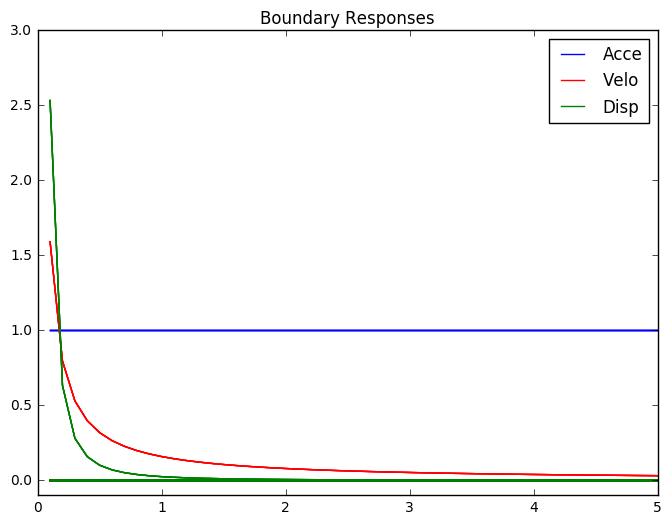

In [27]:
h = plt.plot(freq, abs(sol[0].a[b]).T, 'b',
             freq, abs(sol[0].v[b]).T, 'r',
             freq, abs(sol[0].d[b]).T, 'g')
plt.title('Boundary Responses')
plt.legend(h[::len(b)], ('Acce', 'Velo', 'Disp'), loc='best')
plt.ylim(-.1, 3)
plt.xlim(0, 5)

The modal part has dynamic content as we'll see next. Note: for the x-direction, the modes of interest are above 50 Hz. The other directions have modal content much lower in frequency.

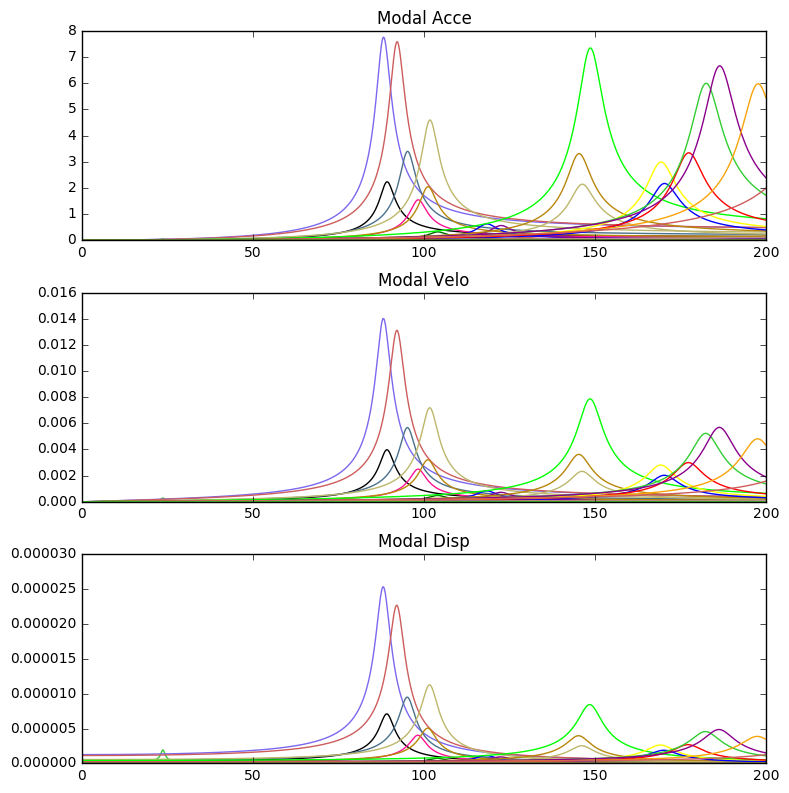

In [16]:
plt.figure(figsize=(8, 8))
plt.subplot(311); plt.plot(freq, abs(sol[0].a[q]).T); plt.title('Modal Acce')
plt.subplot(312); plt.plot(freq, abs(sol[0].v[q]).T); plt.title('Modal Velo')
plt.subplot(313); plt.plot(freq, abs(sol[0].d[q]).T); plt.title('Modal Disp')
plt.tight_layout()

We can plot ``sol.frc`` to see the boundary forces needed to run the base-drive. Here, we'll use the rigid-body modes to sum the forces to the center point and plot that. The starting value for the x-direction should be 1.755 to match the mass.

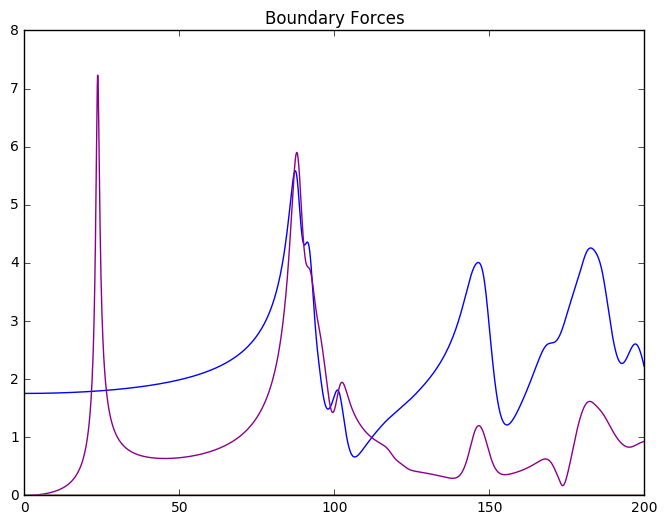

In [17]:
plt.plot(freq, abs(rbg.T @ sol[0].frc).T)
plt.title('Boundary Forces');

---
Finally, let's get to checking the data recovery matrices.

The first one we'll check is the ``SPCF`` recovery. Since that was defined to recovery the boundary forces, the components should match the b-set parts of the mass and stiffness. (Note that ``SPCFD`` loses some precision through the DMAP as compared to the original stiffness.)

In [18]:
assert np.allclose(otm['SPCFA'], maa[b])
assert np.allclose(otm['SPCFD'], kaa[bb])

For the ``ATM``, there should be some lines that start at 1.0. Other lines, should start at zero. These curves make sense.

(0.001, 10)

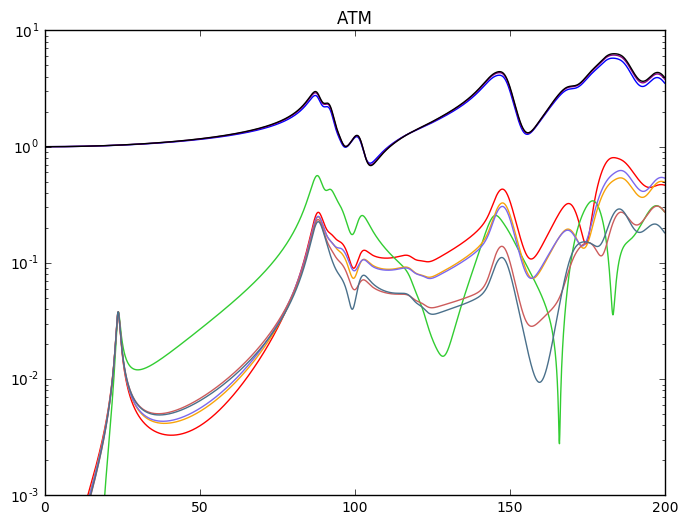

In [19]:
plt.semilogy(freq, abs(otm['ATM'] @ sol[0].a).T)
plt.title('ATM')
plt.ylim(.001, 10)

The ``LTMA`` curves should all start with zero slope. ``LTMD`` curves should be numerically zero since rigid-body displacement should not cause any loads. These look reasonable.

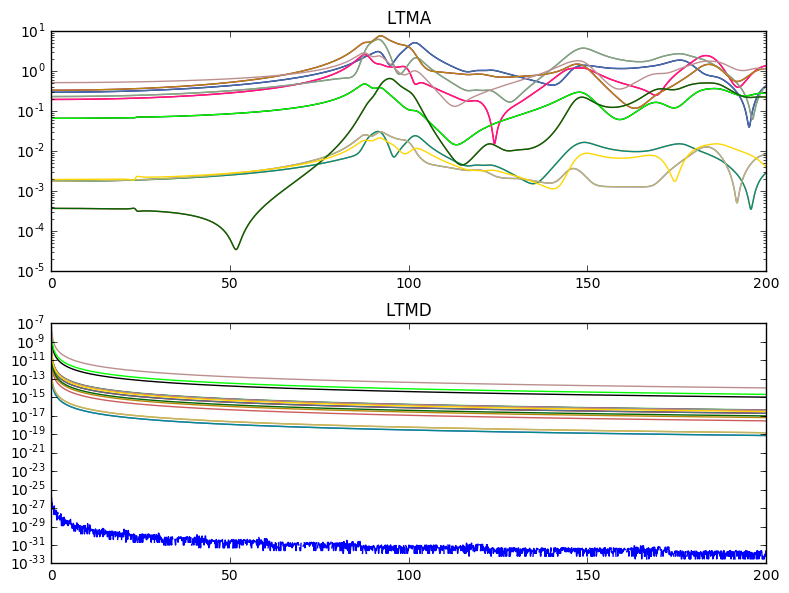

In [20]:
plt.subplot(211)
plt.semilogy(freq, abs(otm['LTMA'] @ sol[0].a).T)
plt.title('LTMA')
plt.subplot(212)
plt.semilogy(freq, abs(otm['LTMD'] @ sol[0].d[b]).T)
plt.title('LTMD')
plt.tight_layout()

The ``DTMA`` curves should also start with zero slope, with values much less than 1.0. Some of the ``DTMD`` curves (the ones in the 'x' direction) should start at high values then quickly drop off as frequency increases.

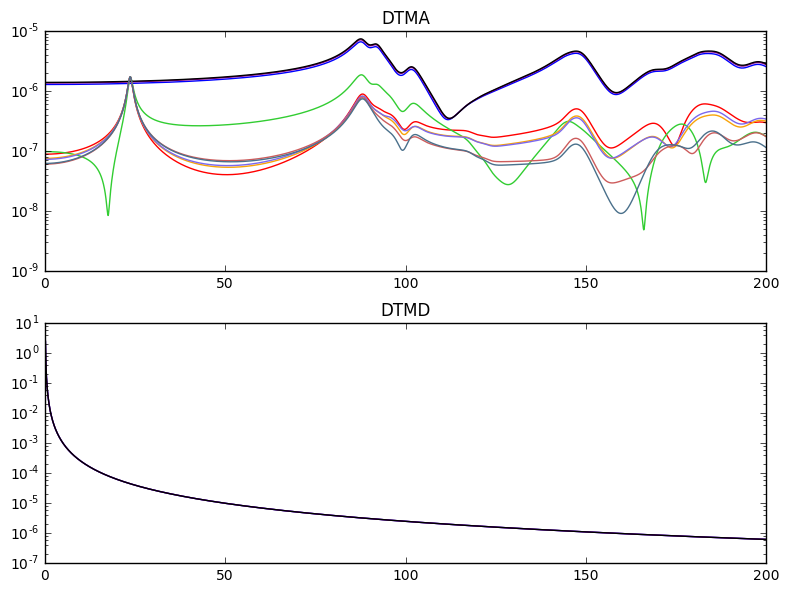

In [21]:
plt.subplot(211)
plt.semilogy(freq, abs(otm['DTMA'] @ sol[0].a).T)
plt.title('DTMA')
plt.subplot(212)
plt.semilogy(freq, abs(otm['DTMD'] @ sol[0].d[b]).T)
plt.title('DTMD')
plt.tight_layout()